<a href="https://colab.research.google.com/github/garbesc/Projet-6/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Import des librairies
import numpy as np
import pandas as pd
import os, sys, time
import math, random
import xml.etree.ElementTree as et

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from skimage import io

import tensorflow as tf
print ("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
%%time
# Contrôle du format des fichiers images
folder_path = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Images/"
files_list = []
for path, dirs, files in os.walk(folder_path):
    for filename in files:
        if (filename.endswith("jpg") & ~filename.endswith("(1).jpg")):
            try:
                fobj = open(path+"/"+filename, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            except:
                continue
            finally:
                fobj.close()

            if is_jfif:
#                print (str(path.replace(folder_path,"")) + " " + str(filename.replace(".jpg","")))
                files_list.append([path.replace(folder_path,""), filename.replace(".jpg","")])
            else:
                os.remove(path+"/"+filename)
                os.remove(path.replace("Images","Annotation")+"/"+filename.replace('.jpg',''))  

CPU times: user 2.23 s, sys: 2.28 s, total: 4.5 s
Wall time: 38.1 s


In [62]:
print (len(files_list))
df=pd.DataFrame(files_list,columns=['folder','filename'])

20634


In [64]:
%%time
annot_path = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Annotation/"
for path, dirs, files in os.walk(annot_path):
    for filename in files:
        if filename.startswith("n"):
            tree = et.parse(path+"/"+filename)
            df.loc[(df['filename']==filename),['width']]  = int(tree.getroot().findall('size')[0].find('width').text)
            df.loc[(df['filename']==filename),['height']] = int(tree.getroot().findall('size')[0].find('height').text)
            df.loc[(df['filename']==filename),['depth']]  = int(tree.getroot().findall('size')[0].find('depth').text)
            df.loc[(df['filename']==filename),['name']]   = tree.getroot().findall('object')[0].find('name').text
            df.loc[(df['filename']==filename),['pose']]   = tree.getroot().findall('object')[0].find('pose').text
            df.loc[(df['filename']==filename),['truncated']] = int(tree.getroot().findall('object')[0].find('truncated').text)
            df.loc[(df['filename']==filename),['difficult']] = int(tree.getroot().findall('object')[0].find('difficult').text)
            df.loc[(df['filename']==filename),['xmin']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            df.loc[(df['filename']==filename),['xmax']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            df.loc[(df['filename']==filename),['ymin']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            df.loc[(df['filename']==filename),['ymax']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)

CPU times: user 16min 7s, sys: 7.89 s, total: 16min 15s
Wall time: 17min 8s


In [66]:
df

,folder,filename,width,height,depth,name,pose,truncated,difficult,xmin,xmax,ymin,ymax
0,n02090622-borzoi,n02090622_2337,225.0,243.0,3.0,borzoi,Unspecified,0.0,0.0,38.0,220.0,17.0,242.0
1,n02090622-borzoi,n02090622_1047,500.0,333.0,3.0,borzoi,Unspecified,0.0,0.0,140.0,296.0,2.0,331.0
2,n02090622-borzoi,n02090622_10302,500.0,366.0,3.0,borzoi,Unspecified,0.0,0.0,168.0,499.0,62.0,365.0
3,n02090622-borzoi,n02090622_10281,500.0,423.0,3.0,borzoi,Unspecified,0.0,0.0,48.0,454.0,26.0,402.0
4,n02090622-borzoi,n02090622_1391,363.0,500.0,3.0,borzoi,Unspecified,0.0,0.0,51.0,262.0,307.0,498.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20629,n02105056-groenendael,n02105056_7355,500.0,333.0,3.0,groenendael,Unspecified,0.0,0.0,212.0,475.0,20.0,332.0
20630,n02105056-groenendael,n02105056_98,352.0,500.0,3.0,groenendael,Unspecified,0.0,0.0,31.0,263.0,98.0,413.0
20631,n02105056-groenendael,n02105056_7381,357.0,500.0,3.0,groenendael,Unspecified,0.0,0.0,46.0,326.0,32.0,483.0
20632,n02105056-groenendael,n02105056_933,166.0,220.0,3.0,groenendael,Unspecified,0.0,0.0,20.0,165.0,10.0,219.0


In [77]:
df.drop(df[df.filename.str.endswith("(1)")].index,axis=0, inplace=True)

In [15]:
df.width.describe()

count    20570.000000
mean       442.455177
std        142.525013
min         97.000000
25%        361.000000
50%        500.000000
75%        500.000000
max       3264.000000
Name: width, dtype: float64

In [78]:
df.height.describe()

count    20570.000000
mean       385.830141
std        124.728289
min        100.000000
25%        333.000000
50%        375.000000
75%        453.000000
max       2562.000000
Name: height, dtype: float64

In [79]:
# Contrôle de la largeur / hauteur
df.loc[(df.width<=256)| (df.height<=256)]

,folder,filename,width,height,depth,name,pose,truncated,difficult,xmin,xmax,ymin,ymax
0,n02090622-borzoi,n02090622_2337,225.0,243.0,3.0,borzoi,Unspecified,0.0,0.0,38.0,220.0,17.0,242.0
21,n02090622-borzoi,n02090622_4797,283.0,243.0,3.0,borzoi,Unspecified,0.0,0.0,19.0,267.0,16.0,234.0
29,n02090622-borzoi,n02090622_3300,250.0,173.0,3.0,borzoi,Unspecified,0.0,0.0,32.0,206.0,11.0,166.0
31,n02090622-borzoi,n02090622_4873,231.0,227.0,3.0,borzoi,Unspecified,0.0,0.0,66.0,219.0,97.0,217.0
36,n02090622-borzoi,n02090622_3763,250.0,216.0,3.0,borzoi,Unspecified,0.0,0.0,0.0,220.0,40.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20562,n02105056-groenendael,n02105056_4766,350.0,249.0,3.0,groenendael,Unspecified,0.0,0.0,19.0,349.0,0.0,248.0
20595,n02105056-groenendael,n02105056_5365,314.0,235.0,3.0,groenendael,Unspecified,0.0,0.0,0.0,263.0,22.0,234.0
20617,n02105056-groenendael,n02105056_6899,190.0,290.0,3.0,groenendael,Unspecified,0.0,0.0,41.0,172.0,21.0,269.0
20625,n02105056-groenendael,n02105056_961,240.0,165.0,3.0,groenendael,Unspecified,0.0,0.0,34.0,239.0,17.0,164.0


In [89]:
# Contrôle de la difficulté et du nombre de couleurs
print (df.loc[df.difficult>0])
print (df.loc[df.depth!=3])

Empty DataFrame
Columns: [folder, filename, width, height, depth, name, pose, truncated, difficult, xmin, xmax, ymin, ymax]
Index: []
Empty DataFrame
Columns: [folder, filename, width, height, depth, name, pose, truncated, difficult, xmin, xmax, ymin, ymax]
Index: []


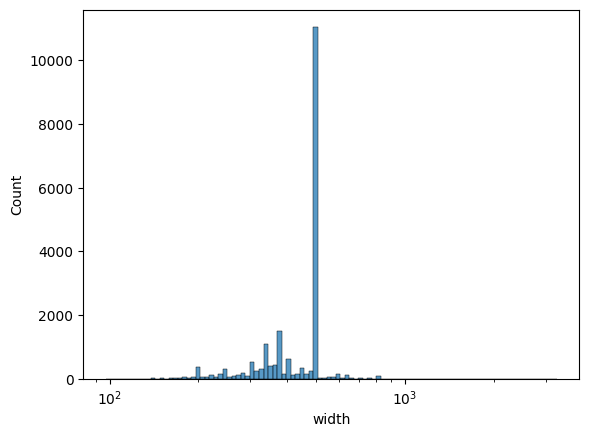

In [81]:
# Statistiques sur la largeur
sns.histplot(data=df, x="width", bins=100, log_scale=True)
plt.show()

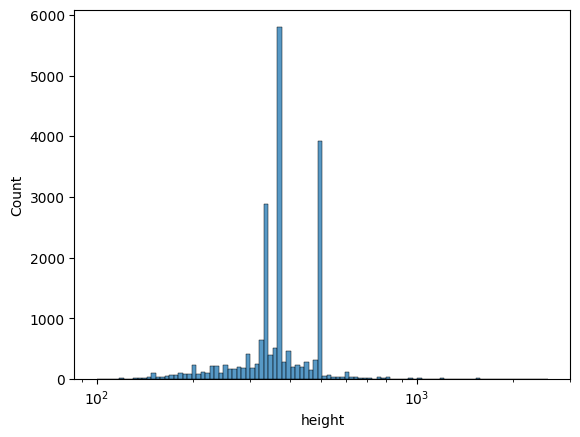

In [82]:
# Statistiques sur la hauteur
sns.histplot(data=df, x="height", bins=100, log_scale=True)
plt.show()

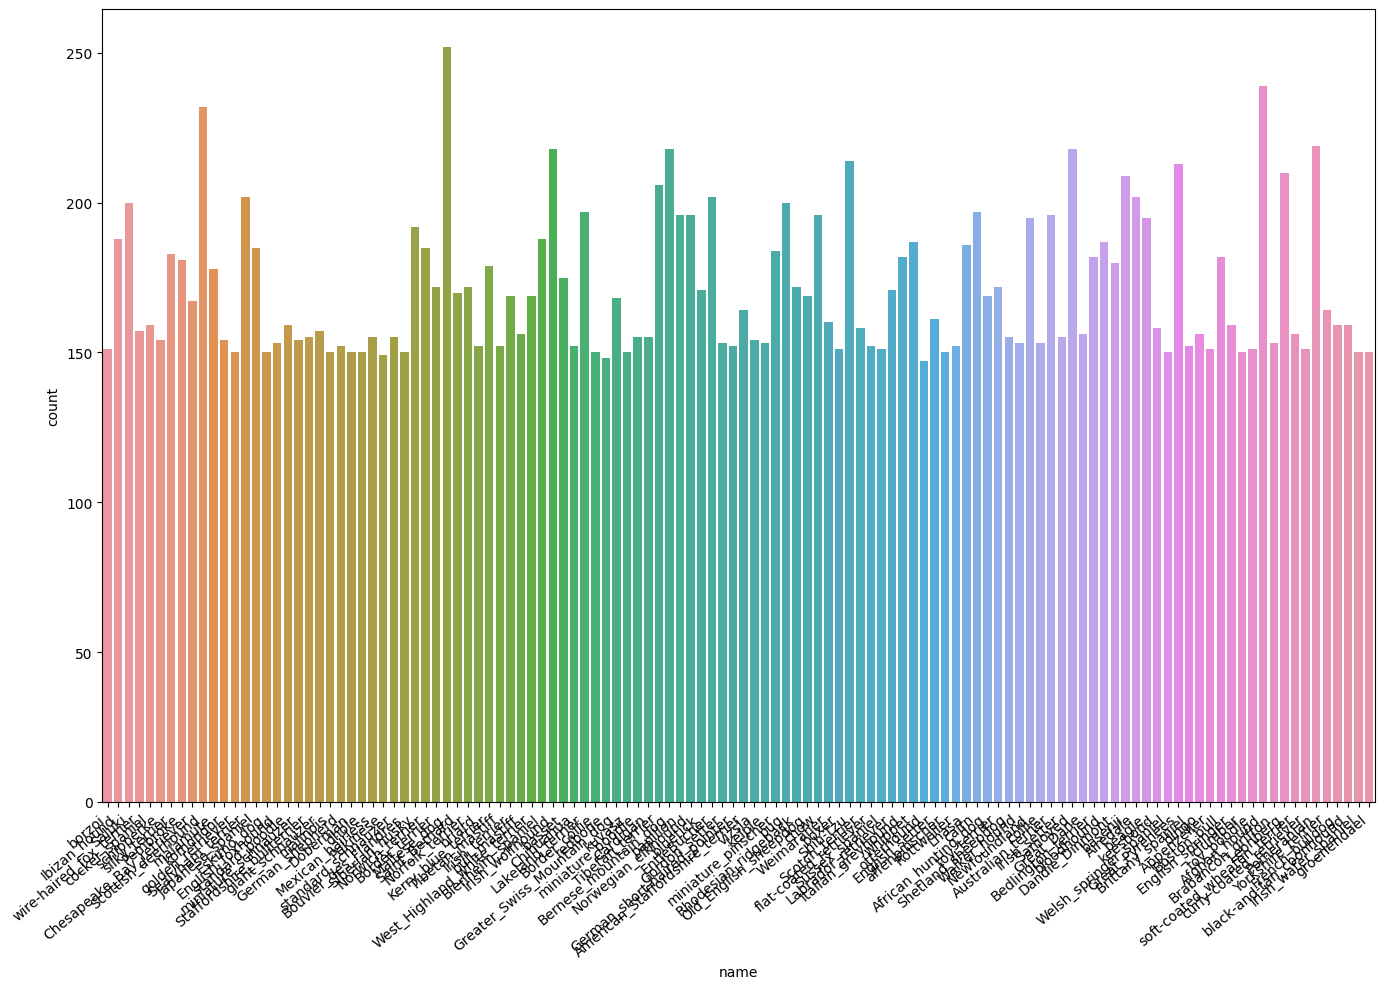

In [84]:
# Statistiques sur les races
plt.figure(figsize=(14,10))
ax = sns.countplot(data=df, x="name")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [85]:
# Mémorisation des races dans une liste
y = df['folder'].to_list()

In [ ]:
X = []
for path, dirs, files in os.walk(folder_path):
    for filename in files:
        if (filename.endswith("jpg") & ~filename.endswith("(1).jpg")):
            image=io.imread(f'{path}/{filename}')
            X.append(image)
X.shape

In [86]:
X, y = np.array(x,dtype=object),np.array(y)

NameError: ignored

In [ ]:
# Recadrage des images (cropping)
# exemple
file_test = folder_path + "/n02085620-Chihuahua/n02085620_2937.jpg"
image_test = io.imread(file_test)
image_test.show()
image_cropped = image_test.crop((121, 28, 256, 192))
image_cropped.show()

for path, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith("jpg"):
          image = io.imread(path+"/"+filename, mode="w")
          xmin, ymin, xmax, ymax = df.loc[df['filename']==filename, ['xmin', 'ymin','xmax', 'ymax']]
          image_cropped = image.crop((xmin, ymin, xmax, ymax))
          image_cropped.save(path+"/"+filename)